In [4]:
!git clone https://github.com/yarathealmighty/dumps.git

fatal: destination path 'dumps' already exists and is not an empty directory.


In [5]:
!pip install transformers datasets evaluate accelerate

In [31]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import dumps.utils as utils
import matplotlib.pyplot as plt

In [7]:
def preprocess_function(examples):
    label = examples["score"]
    examples = tokenizer(examples["question"],examples['answer'], truncation=True, padding="max_length", max_length=256)

    # Change this to real number
    examples["label"] = float(label)
    return examples

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    single_squared_errors = ((logits - labels).flatten()**2).tolist()

    # Compute accuracy
    # Based on the fact that the rounded score = true score only if |single_squared_errors| < 0.5
    accuracy = sum([1 for e in single_squared_errors if e < 0.5]) / len(single_squared_errors)

    return {"mse": mse, "mae": mae, "r2": r2, "accuracy": accuracy}

def to_ds(df_og,debug_mode=False):
  df = utils.get_qas(df_og)

  if debug_mode:
    df = utils.normalize_scores(df,False)
    df = df[df['normalized_score'].notna()]

  else:
    df = utils.normalize_scores(df)
    df = df[df['score'].notna()]

  #se as in StackExchange
  se = Dataset.from_pandas(df)
  train_test_split = se.train_test_split(test_size=0.2, seed=42)

  se = DatasetDict({
    'train': train_test_split['train'],
    'test': train_test_split['test']
  })

  for split in se:
    se[split] = se[split].map(preprocess_function, remove_columns=["score",'__index_level_0__'])

  return se

In [8]:
#--------------------------------------<paths>---------------------------------------------

FILENAME = 'movies.csv'

#--------------------------------------<model_params>--------------------------------------

BASE_MODEL = "distilbert/distilbert-base-uncased"
LEARNING_RATE = 2e-5
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 20

#------------------------------------------------------------------------------------------

In [9]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model che

In [22]:
# using <insert current stack exchange forum here> SE here
df = pd.read_csv('dumps/data/parsed/' + FILENAME)
se = to_ds(df)

Map:   0%|          | 0/19983 [00:00<?, ? examples/s]

Map:   0%|          | 0/4996 [00:00<?, ? examples/s]

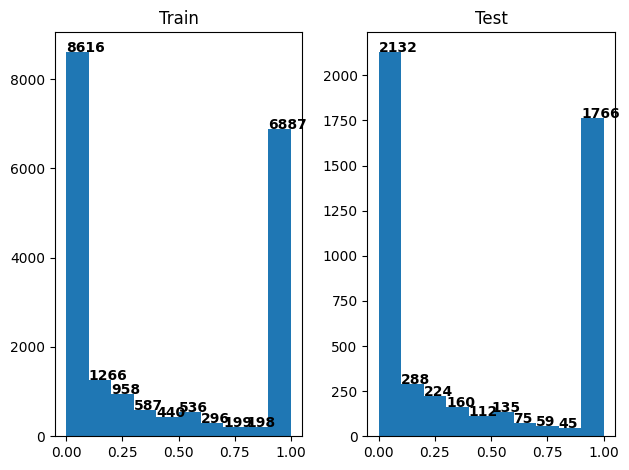

In [11]:
fig, axs = plt.subplots(1, 2, tight_layout=True)
distributions = []

axs[0].set_title("Train"); axs[1].set_title("Test");
train_distributions = axs[0].hist(se['train']["label"], bins=10)
test_distributions = axs[1].hist(se['test']["label"], bins=10)

for distributions, ax in zip([train_distributions, test_distributions], axs):
    for j in range(10):
        # Display the counts on each column of the histograms
        ax.text(distributions[1][j], distributions[0][j], str(int(distributions[0][j])), weight="bold")

In [12]:
training_args = TrainingArguments(
    output_dir="models/distilbert/"+FILENAME[:-4],
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=20,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [13]:
class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0][:, 0]
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [14]:
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=se["train"],
    eval_dataset=se["test"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Accuracy
1,0.187400,0.186898,0.186898,0.403502,0.071883,0.996197
2,0.170400,0.194393,0.194393,0.392612,0.034665,0.926141
3,0.126700,0.213190,0.213190,0.381640,-0.058679,0.850080
4,0.072400,0.238701,0.238701,0.384119,-0.185366,0.788030
5,0.045600,0.286917,0.286917,0.407146,-0.424801,0.733187
6,0.032800,0.299190,0.299190,0.410032,-0.485748,0.723379
7,0.026700,0.276630,0.276630,0.397099,-0.373716,0.730184
8,0.021600,0.289214,0.289214,0.405832,-0.436207,0.720777
9,0.020000,0.271885,0.271885,0.394482,-0.350154,0.744796
10,0.016700,0.275645,0.275645,0.395917,-0.368826,0.738591


Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Accuracy
1,0.187400,0.186898,0.186898,0.403502,0.071883,0.996197
2,0.170400,0.194393,0.194393,0.392612,0.034665,0.926141
3,0.126700,0.213190,0.213190,0.381640,-0.058679,0.850080
4,0.072400,0.238701,0.238701,0.384119,-0.185366,0.788030
5,0.045600,0.286917,0.286917,0.407146,-0.424801,0.733187
6,0.032800,0.299190,0.299190,0.410032,-0.485748,0.723379
7,0.026700,0.276630,0.276630,0.397099,-0.373716,0.730184
8,0.021600,0.289214,0.289214,0.405832,-0.436207,0.720777
9,0.020000,0.271885,0.271885,0.394482,-0.350154,0.744796
10,0.016700,0.275645,0.275645,0.395917,-0.368826,0.738591


TrainOutput(global_step=24980, training_loss=0.04055107589527738, metrics={'train_runtime': 9885.3167, 'train_samples_per_second': 40.43, 'train_steps_per_second': 2.527, 'total_flos': 2.647048820143104e+16, 'train_loss': 0.04055107589527738, 'epoch': 20.0})

In [15]:
trainer.eval_dataset=se["test"]
eval = trainer.evaluate()

EVAL_FILENAME = "eval_"+FILENAME[:-4]+".txt"

with open(EVAL_FILENAME, "w") as file:
    file.write(str(eval))
    file.close()

In [28]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

df = pd.read_csv('dumps/data/parsed/' + FILENAME)
df = utils.get_qas(df)
df = utils.normalize_scores(df)
df = df[df['score'].notna()]

# linear
lin_reg = LinearRegression()

# ridge
ridge = Ridge(alpha=1.0)

# lasso
lasso = Lasso(alpha=0.1)

# svr
svr = SVR(kernel='rbf')

# rfr
rfr = RandomForestRegressor(n_estimators=100)

# gbr
gbr = GradientBoostingRegressor(n_estimators=100)

# k neighbors
kn = KNeighborsRegressor(n_neighbors=5)

In [1]:
df

NameError: name 'df' is not defined

In [ ]:
# early modellek kiértékelése
# sklearn regressorok

In [16]:
# ----------------------------------------------------------<HF params>----------------------------------------------------------

model_repo_id = 'yarathealmighty/test-movies'
ds_repo_id = 'yarathealmighty/dumps'
access_token = 'hf_yourtoken'

# --------------------------------------------------------<HF code below>--------------------------------------------------------

from huggingface_hub import HfApi

api = HfApi()

api.upload_folder(
    folder_path="models/distilbert/"+FILENAME[:-4],
    repo_id=model_repo_id,
    repo_type="model",
    token=access_token
)

se['train'].push_to_hub(
    'yarathealmighty/dumps',
    'train',
    token=access_token
)
se['test'].push_to_hub(
    'yarathealmighty/dumps',
    'test',
    token=access_token
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

Upload 99 LFS files:   0%|          | 0/99 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

events.out.tfevents.1725960383.dcee7a4ae5ef.754.0:   0%|          | 0.00/5.78k [00:00<?, ?B/s]

events.out.tfevents.1725961007.dcee7a4ae5ef.754.1:   0%|          | 0.00/4.18k [00:00<?, ?B/s]

events.out.tfevents.1725961185.dcee7a4ae5ef.4273.0:   0%|          | 0.00/25.0k [00:00<?, ?B/s]

events.out.tfevents.1725971139.dcee7a4ae5ef.4273.1:   0%|          | 0.00/560 [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/20 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/876 [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/yarathealmighty/dumps/commit/95ac892c6ec6af3242d2ad405a4eb47040e11163', commit_message='Upload dataset', commit_description='', oid='95ac892c6ec6af3242d2ad405a4eb47040e11163', pr_url=None, pr_revision=None, pr_num=None)